In [79]:
# Set the kernel for the notebook
# Activate the .venv environment
!source .venv/bin/activate

zsh:source:1: no such file or directory: .venv/bin/activate


In [80]:
%pip install pandas seaborn matplotlib 

You should consider upgrading via the '/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [81]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
df = pd.read_csv(current_dir.parent/ "data" /"college" / "college_stats_all_seasons.csv")
df.head()

,draft_year,player_slug,player_name,Season,Age,College,G,MP,Totals_FG,Totals_FGA,...,Totals_TOV,Totals_PF,Totals_PTS,Shooting_FG%,Shooting_3P%,Shooting_FT%,Per Game_MP,Per Game_PTS,Per Game_TRB,Per Game_AST
0,2000,martike01,Kenyon Martin,1996-97,19.0,CINCY,22,233.0,26,40,...,16.0,51.0,62,0.650,NaN,0.313,10.6,2.8,3.4,0.5
1,2000,martike01,Kenyon Martin,1997-98,20.0,CINCY,30,858.0,124,198,...,52.0,109.0,298,0.626,0.000,0.476,28.6,9.9,8.9,1.4
2,2000,martike01,Kenyon Martin,1998-99,21.0,CINCY,33,900.0,142,248,...,67.0,109.0,334,0.573,0.000,0.562,27.3,10.1,6.9,1.5
3,2000,martike01,Kenyon Martin,1999-00,22.0,CINCY,31,909.0,221,389,...,56.0,71.0,585,0.568,0.286,0.684,29.3,18.9,9.7,1.4
4,2000,martike01,Kenyon Martin,Career,NaN,NaN,116,2900.0,513,875,...,191.0,340.0,1279,0.586,0.222,0.581,25.0,11.0,7.5,1.2


#### 1. Strip Column Names and Values

In [82]:
# Strip white spaces from column names
df.columns = df.columns.str.strip()

# Strip white spaces from column values
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

df.columns.tolist()

/var/folders/b9/7xp5dt9d5nd0hct357z94wgh0000gn/T/ipykernel_96710/1257809352.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


['draft_year',
 'player_slug',
 'player_name',
 'Season',
 'Age',
 'College',
 'G',
 'MP',
 'Totals_FG',
 'Totals_FGA',
 'Totals_3P',
 'Totals_3PA',
 'Totals_FT',
 'Totals_FTA',
 'Totals_ORB',
 'Totals_TRB',
 'Totals_AST',
 'Totals_STL',
 'Totals_BLK',
 'Totals_TOV',
 'Totals_PF',
 'Totals_PTS',
 'Shooting_FG%',
 'Shooting_3P%',
 'Shooting_FT%',
 'Per Game_MP',
 'Per Game_PTS',
 'Per Game_TRB',
 'Per Game_AST']

#### 2. Remove Unnecessary Columns

In [83]:
cols_to_drop = [
    "player_slug",
]

df = df.drop(columns=cols_to_drop)


#### 2. Remove NBA Career Rows


In [84]:
# Remove rows with feaeture "Season" = Career

df = df[df['Season'] != 'Career']
df.head()

,draft_year,player_name,Season,Age,College,G,MP,Totals_FG,Totals_FGA,Totals_3P,...,Totals_TOV,Totals_PF,Totals_PTS,Shooting_FG%,Shooting_3P%,Shooting_FT%,Per Game_MP,Per Game_PTS,Per Game_TRB,Per Game_AST
0,2000,Kenyon Martin,1996-97,19.0,CINCY,22,233.0,26,40,0,...,16.0,51.0,62,0.650,NaN,0.313,10.6,2.8,3.4,0.5
1,2000,Kenyon Martin,1997-98,20.0,CINCY,30,858.0,124,198,0,...,52.0,109.0,298,0.626,0.000,0.476,28.6,9.9,8.9,1.4
2,2000,Kenyon Martin,1998-99,21.0,CINCY,33,900.0,142,248,0,...,67.0,109.0,334,0.573,0.000,0.562,27.3,10.1,6.9,1.5
3,2000,Kenyon Martin,1999-00,22.0,CINCY,31,909.0,221,389,2,...,56.0,71.0,585,0.568,0.286,0.684,29.3,18.9,9.7,1.4
5,2000,Stromile Swift,1998-99,19.0,LSU,16,319.0,45,110,1,...,46.0,43.0,121,0.409,0.125,0.600,19.9,7.6,4.3,0.3


#### 3. Retain only the last season of each player 

In [85]:
# Convert "Season" into a sortable numeric year
df["season_start"] = df["Season"].str[:4].astype(int)

# For each (player_name, draft_year, College), get the index of the latest season
idx_last = (
    df.groupby(["player_name", "draft_year", "College"])["season_start"]
      .idxmax()
)

# Extract only the last-season rows
last_season_df = df.loc[idx_last].reset_index(drop=True)

# Drop helper column
last_season_df = last_season_df.drop(columns=["season_start"])

# Drop column "Season"
last_season_df = last_season_df.drop(columns=["Season"])

In [86]:
## missing values report

def missing_report(dataframe):
    report = (
        dataframe.isna()
        .sum()
        .to_frame("missing_count")
    )
    report["total_rows"] = len(dataframe)
    report["missing_percent"] = (report["missing_count"] / report["total_rows"]) * 100
    report["non_missing_count"] = report["total_rows"] - report["missing_count"]

    return report[[
        "missing_count",
        "non_missing_count",
        "missing_percent"
    ]].sort_values("missing_percent", ascending=False)


missing_report(df)

,missing_count,non_missing_count,missing_percent
Shooting_3P%,321,2737,10.497057
Totals_ORB,140,2918,4.578156
Totals_PF,14,3044,0.457816
Totals_STL,11,3047,0.359712
Totals_TOV,11,3047,0.359712
Totals_BLK,11,3047,0.359712
Shooting_FT%,6,3052,0.196207
Per Game_MP,5,3053,0.163506
MP,5,3053,0.163506
Shooting_FG%,2,3056,0.065402


_There is no missing values in the dataset, but we have scraped only if there is college stats Table from sports-reference.com_

In [87]:
last_season_df.sort_values(by=["draft_year", "Totals_PTS"], inplace=True)

last_season_df.to_csv(current_dir.parent/ "data"/ "college"/'players_last_season.csv', index=False)

#### 4. Combine NBA Draft Combine and College Player Data

In [88]:
college_df = last_season_df.copy()
draft_df = pd.read_csv(current_dir.parent /"outputs" / "nba_combine.csv")

merged_df = pd.merge(
    draft_df,
    college_df,              
    left_on=["PLAYER_NAME", "SEASON"],
    right_on=["player_name", "draft_year"],
    how="inner",                     # ⬅️ keep ALL rows from draft_df
    suffixes=("_DRAFT", "_COMBINE")
)

# Remove duplicates if any
merged_df = merged_df.drop_duplicates()

# Sort by season and draft order
merged_df = merged_df.sort_values(by=["SEASON", "OVERALL_PICK"])
print(f"Shape of merged_df: {merged_df.shape}")
merged_df.head()


Shape of merged_df: (1210, 51)


,PERSON_ID,PLAYER_NAME,SEASON,ROUND_NUMBER,OVERALL_PICK,TEAM_NAME,ORGANIZATION,ORGANIZATION_TYPE,PLAYER_PROFILE_FLAG,POSITION,...,Totals_TOV,Totals_PF,Totals_PTS,Shooting_FG%,Shooting_3P%,Shooting_FT%,Per Game_MP,Per Game_PTS,Per Game_TRB,Per Game_AST
0,2030,Kenyon Martin,2000,1,1,Nets,Cincinnati,College/University,1,NaN,...,56.0,71.0,585,0.568,0.286,0.684,29.3,18.9,9.7,1.4
1,2031,Stromile Swift,2000,1,2,Grizzlies,Louisiana State,College/University,1,NaN,...,80.0,88.0,550,0.608,0.280,0.617,29.8,16.2,8.2,0.9
2,2033,Marcus Fizer,2000,1,4,Bulls,Iowa State,College/University,1,NaN,...,77.0,103.0,844,0.582,0.357,0.732,33.6,22.8,7.7,1.1
3,2034,Mike Miller,2000,1,5,Magic,Florida,College/University,1,NaN,...,71.0,70.0,521,0.476,0.338,0.729,28.6,14.1,6.6,2.5
4,2035,DerMarr Johnson,2000,1,6,Hawks,Cincinnati,College/University,1,NaN,...,46.0,64.0,402,0.478,0.371,0.737,27.5,12.6,3.8,1.4


#### 3. Keep Columsn with 0 missing values

In [89]:
df = merged_df.copy()
df = df.drop(columns=['PLAYER_NAME', 'draft_year', 'PERSON_ID']) # duplicate columns

# Keep only columns that have 0 missing values
df_clean = df.loc[:, df.isna().sum() == 0]
df_clean.columns

Index(['SEASON', 'ROUND_NUMBER', 'OVERALL_PICK', 'TEAM_NAME', 'ORGANIZATION',
       'ORGANIZATION_TYPE', 'PLAYER_PROFILE_FLAG', 'player_name', 'Age',
       'College', 'G', 'Totals_FG', 'Totals_FGA', 'Totals_3P', 'Totals_3PA',
       'Totals_FT', 'Totals_FTA', 'Totals_TRB', 'Totals_AST', 'Totals_PTS',
       'Per Game_PTS', 'Per Game_TRB', 'Per Game_AST'],
      dtype='object')

In [90]:
import numpy as np
import pandas as pd

# If df_clean was made from df using slicing, reset it properly:
df_clean = df.copy()   # ensures no SettingWithCopyWarning

cols_to_fix = [
    'Age', 'MP', 'Totals_ORB', 'Totals_STL', 'Totals_BLK',
    'Totals_TOV', 'Totals_PF',
    'Shooting_FG%', 'Shooting_3P%', 'Shooting_FT%',
    'Per Game_MP'
]

for col in cols_to_fix:
    # Convert to string and strip spaces
    s = df_clean[col].astype(str).str.strip()
    
    # Remove percentage signs if present
    s = s.str.replace('%', '', regex=False)
    
    # Replace empty strings with NaN
    s = s.replace('', np.nan)
    
    # Convert to numeric using .loc to avoid warnings
    df_clean.loc[:, col] = pd.to_numeric(s, errors='coerce')

# Fill missing values with median -- again use .loc
df_clean.loc[:, cols_to_fix] = df_clean[cols_to_fix].fillna(df_clean[cols_to_fix].median())


#### 4. Feature Selection using Correlation

In [91]:
df_clean.columns

Index(['SEASON', 'ROUND_NUMBER', 'OVERALL_PICK', 'TEAM_NAME', 'ORGANIZATION',
       'ORGANIZATION_TYPE', 'PLAYER_PROFILE_FLAG', 'POSITION', 'HEIGHT',
       'WEIGHT', 'WINGSPAN', 'BODY_FAT_PCT', 'HAND_LENGTH', 'HAND_WIDTH',
       'STANDING_VERTICAL_LEAP', 'MAX_VERTICAL_LEAP', 'LANE_AGILITY_TIME',
       'MODIFIED_LANE_AGILITY_TIME', 'THREE_QUARTER_SPRINT', 'BENCH_PRESS',
       'BMI', 'VERTICAL_RATIO', 'player_name', 'Age', 'College', 'G', 'MP',
       'Totals_FG', 'Totals_FGA', 'Totals_3P', 'Totals_3PA', 'Totals_FT',
       'Totals_FTA', 'Totals_ORB', 'Totals_TRB', 'Totals_AST', 'Totals_STL',
       'Totals_BLK', 'Totals_TOV', 'Totals_PF', 'Totals_PTS', 'Shooting_FG%',
       'Shooting_3P%', 'Shooting_FT%', 'Per Game_MP', 'Per Game_PTS',
       'Per Game_TRB', 'Per Game_AST'],
      dtype='object')

In [92]:
stat_columns = [
    'Age', 'G', 'MP',
    'Totals_FG', 'Totals_FGA', 'Totals_3P', 'Totals_3PA',
    'Totals_FT', 'Totals_FTA', 'Totals_ORB', 'Totals_TRB',
    'Totals_AST', 'Totals_STL', 'Totals_BLK', 'Totals_TOV',
    'Totals_PF', 'Totals_PTS',
    'Shooting_FG%', 'Shooting_3P%', 'Shooting_FT%',
    'Per Game_MP', 'Per Game_PTS', 'Per Game_TRB', 'Per Game_AST','OVERALL_PICK', 'player_name','SEASON'
]

df_feats = df_clean[stat_columns]

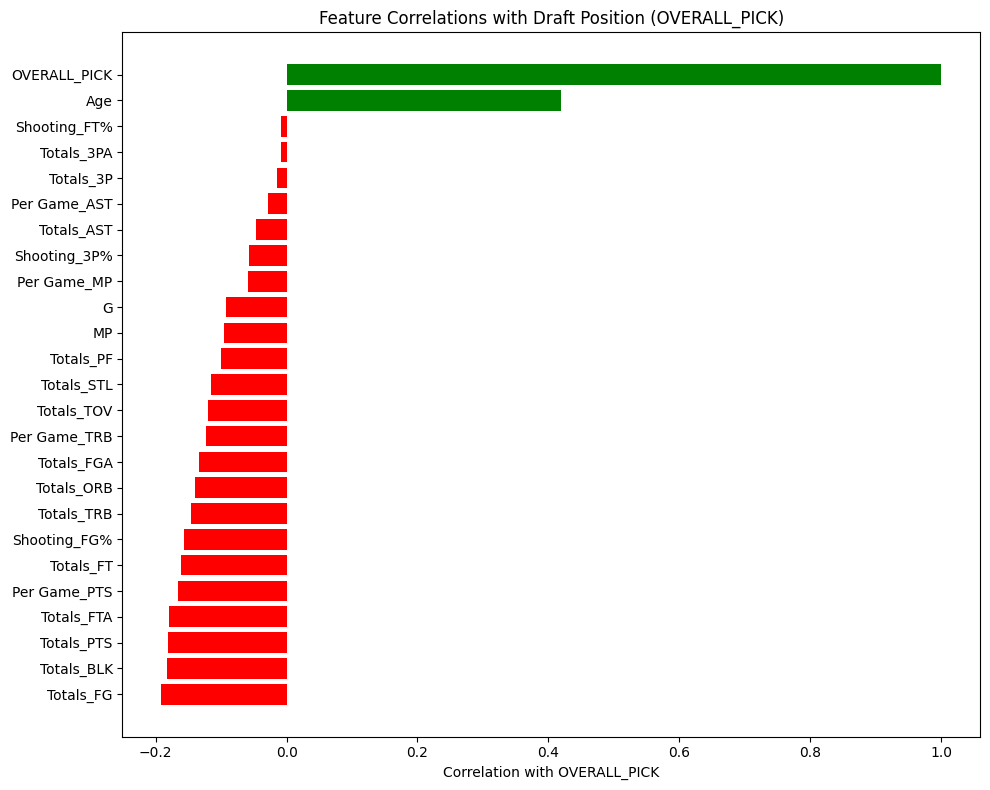

OVERALL_PICK    1.000000
Age             0.419274
Totals_FG       0.191419
Totals_BLK      0.183006
Totals_PTS      0.180855
Totals_FTA      0.179539
Per Game_PTS    0.166266
Totals_FT       0.161930
Shooting_FG%    0.157000
Totals_TRB      0.146642
Totals_ORB      0.140224
Totals_FGA      0.134456
Per Game_TRB    0.123727
Totals_TOV      0.119511
Totals_STL      0.115570
Totals_PF       0.099742
MP              0.094908
G               0.092979
Per Game_MP     0.058418
Shooting_3P%    0.056741
Totals_AST      0.046671
Per Game_AST    0.028699
Totals_3P       0.013947
Totals_3PA      0.009215
Shooting_FT%    0.008133
Name: OVERALL_PICK, dtype: float64

In [93]:
import matplotlib.pyplot as plt

# Remove non-numeric or irrelevant columns
df_corr = df_feats.drop(columns=['player_name', 'SEASON'], errors='ignore')

# Compute correlations
corr_target = df_corr.corr()['OVERALL_PICK'].sort_values(ascending=False)

# Set colors: green for positive, red for negative
colors = ['green' if v > 0 else 'red' for v in corr_target.values]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(corr_target.index, corr_target.values, color=colors)
plt.xlabel("Correlation with OVERALL_PICK")
plt.title("Feature Correlations with Draft Position (OVERALL_PICK)")
plt.gca().invert_yaxis()  # Highest correlation at the top
plt.tight_layout()
plt.show()

# If you want absolute sorted values:
corr_abs = df_corr.corr()['OVERALL_PICK'].abs().sort_values(ascending=False)
corr_abs


##### 4.1 Keep feature > 0.10 correlation with target

In [94]:
# Remove unwanted columns before correlation
df_corr = df_feats.drop(columns=['player_name', 'SEASON'], errors='ignore')

# Compute absolute correlations with OVERALL_PICK
corr = df_corr.corr()['OVERALL_PICK'].abs().sort_values(ascending=False)

# Select features with threshold
selected_by_corr = corr[corr >= 0.10].index.tolist()

selected_by_corr


['OVERALL_PICK',
 'Age',
 'Totals_FG',
 'Totals_BLK',
 'Totals_PTS',
 'Totals_FTA',
 'Per Game_PTS',
 'Totals_FT',
 'Shooting_FG%',
 'Totals_TRB',
 'Totals_ORB',
 'Totals_FGA',
 'Per Game_TRB',
 'Totals_TOV',
 'Totals_STL']

_From selected_by_corr, many stats are redundant (e.g., FG, FGA, FT, FTA, PTS all measure scoring).
So we keep one representative from each group:._

Final Feature Selection Summary

1. Scoring  
   **Features:** `Totals_FG`, `Totals_PTS`, `Totals_FGA`, `Totals_FT`, `Totals_FTA`, `Per Game_PTS`  
   **Keep:** `Totals_FG`

2. Free Throws
   Features: `Totals_FT`, `Totals_FTA`
   Keep: `Totals_FT` 

3. Rebounding  
   **Features:** `Totals_TRB`, `Totals_ORB`, `Per Game_TRB`  
   **Keep:** `Totals_TRB`

4. Defense  
   **Features:** `Totals_BLK`, `Totals_STL`  
   **Keep:** `Totals_BLK`, `Totals_STL`

5. Efficiency  
   **Features:** `Shooting_FG%`  
   **Keep:** `Shooting_FG%`

6. Turnovers  
   **Features:** `Totals_TOV`  
   **Keep:** `Totals_TOV`

7. Playing Time  
   **Features:** `MP`, `G`  
   **Keep:** `MP`

8. Personal Fouls  
   **Features:** `Totals_PF`  
   **Keep:** `Totals_PF`
   

9. Age / Experience  
   **Features:** `Age`  
   **Keep:** `Age`


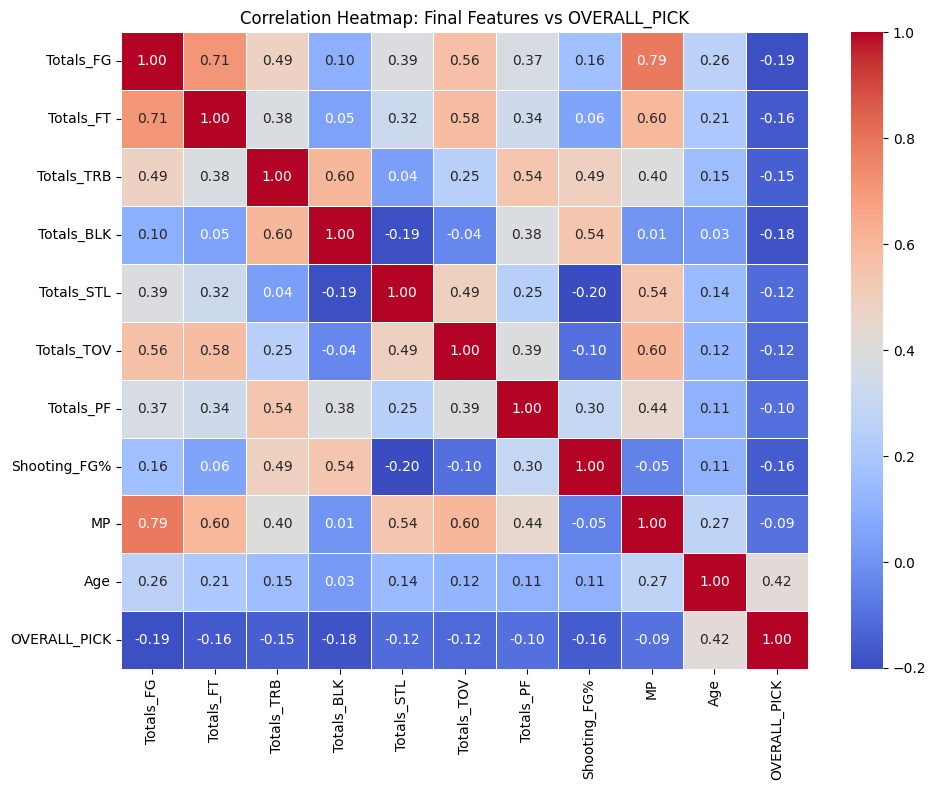

In [95]:
import seaborn as sns 

# Final selected features
final_features = [
    'Totals_FG',
    'Totals_FT',
    'Totals_TRB',
    'Totals_BLK',
    'Totals_STL',
    'Totals_TOV',
    'Totals_PF',
    'Shooting_FG%',
    'MP',
    'Age'
]

heatmap_features = final_features + ['OVERALL_PICK']

# Compute correlation matrix
corr_matrix = df_feats[heatmap_features].corr()

# Draw heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Final Features vs OVERALL_PICK")
plt.tight_layout()
plt.show()



In [96]:
df_feats.columns

Index(['Age', 'G', 'MP', 'Totals_FG', 'Totals_FGA', 'Totals_3P', 'Totals_3PA',
       'Totals_FT', 'Totals_FTA', 'Totals_ORB', 'Totals_TRB', 'Totals_AST',
       'Totals_STL', 'Totals_BLK', 'Totals_TOV', 'Totals_PF', 'Totals_PTS',
       'Shooting_FG%', 'Shooting_3P%', 'Shooting_FT%', 'Per Game_MP',
       'Per Game_PTS', 'Per Game_TRB', 'Per Game_AST', 'OVERALL_PICK',
       'player_name', 'SEASON'],
      dtype='object')

In [97]:
cols_to_export = ['player_name', 'OVERALL_PICK','SEASON'] + final_features

df_feats[cols_to_export].to_csv(current_dir.parent/"outputs"/ "college_stats.csv", index=False)
